# Integrate a function with Gauss-Kronrod algorithm

Reference
* "Methods of numerical integration", P.J.Davis and P.Rabinowitz. (1975) Academic Press. Section "2.7.1.1 "The Kronrod scheme", p. 82 and section 6.2.0 "An iterative nonadaptive scheme based on Kronrod formulas" p.321.
* "Numerical methods in scientific computing, Volume 1", G.Dahlquist and A. Björck. SIAM. (2008). p.575. 

In [1]:
import openturns as ot
import numpy as np
import pylab as pl

## Introduction

In this example, we present the `GaussKronrod` algorithm for one dimensional integration. That is, the algorithm can approximate the integral :

$$
\int_a^b f(x) dx
$$

where $f:[a,b] \rightarrow \mathbb{R}^p$ is a function, $[a,b] \subset \mathbb{R}$ with $a\leq b$ is a one dimensional interval and $p$ is the dimension of the output.
Notice that the dimension of the input must be equal to 1, but the number of outputs can be greater than 1.

Suppose that we have estimated the integral with Gaussian quadrature and $m$ quadrature nodes. If we want to improve the accuracy and use more nodes, the issue is that the new nodes do not correspond to the old ones: therefore, we cannot reuse the function evaluations. 

The Gauss-Kronrod algorithm improves the situation by using two different methods:
* a Gaussian quadrature rule with $m$ nodes, 
* a Kronrod extension with $2m+1$ nodes.

The rule $(G_m,K_{2m+1})$ is called a Gauss-Kronrod pair. In the Kronrod extension, the first $m$ nodes are equal to the nodes in Gaussian quadrature. 

The Gaussian quadrature rule with $m$ nodes is exact for polynomials of degree $2m-1$. The Kronrod extension with $2m+1$ nodes is designed to be exact for polynomials of degree $3m+1$. 

The choice of the weight function $w(x)$ determines the nodes. We consider the weight $w(x)=1$ and the interval $[a,b]=[-1,1]$ (it is straightforward to generalize this for an arbitrary interval $[a,b]$). 
In this case, the new $m+1$ nodes of the Kronrod extension interlaces with the Gaussian nodes. The weights are guaranteed to be positive (an essential property for numerical stability). 

## Example

The following example is from Davis, Rabinowitz, p.325:

$$
\int_0^1 \frac{2}{2 + sin(10 \pi x)} dx = \frac{2}{\sqrt{3}} = 1.154700538379251529.
$$

We first define the function as a `SymbolicFunction`. 

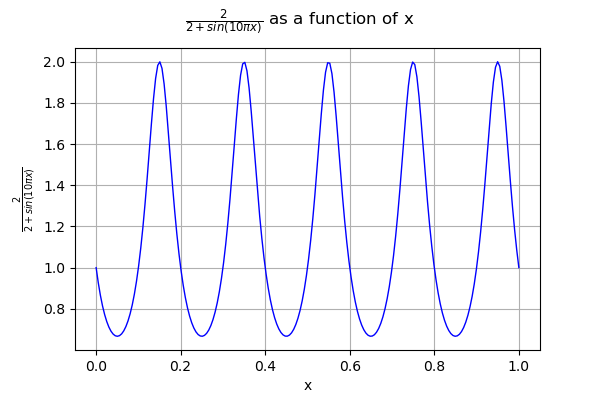

In [2]:
integrand = ot.SymbolicFunction(["x"], ["2 / (2 + sin(10 * pi_ * x))"])
integrand.setOutputDescription([r"$\frac{2}{2 + sin(10 \pi x)}$"])
integrand.draw(0.0, 1.0, 200)

We see that regular spikes and valleys will make this function difficult to integrate, because of the large curvatures implied at these points. 

We will later count the number of function evaluations. But a small amount of function evaluations has already been used for the plot and this is why we must take it into account. 

In [3]:
before_evaluation_number = integrand.getEvaluationCallsNumber()
before_evaluation_number

200

## Basic use

We first chose the Gauss-Kronrod rule. Six methods are available: we select the "G11K23" rule. It uses 11 nodes from a Gauss rule and 23 nodes from a Kronrod rule, re-using the nodes from the Gauss rule. 

In [4]:
quadrature_rule = ot.GaussKronrodRule(ot.GaussKronrodRule.G11K23)

We set the maximum number of sub-intervals and the maximum absolute error.

In [5]:
maximumSubIntervals = 100
maximumError = 1.0e-8
algo = ot.GaussKronrod(maximumSubIntervals, maximumError, quadrature_rule)

In [6]:
interval = ot.Interval(0.0, 1.0)
computed = algo.integrate(integrand, interval)
computed[0]

1.1547005383792528

Notice that the algorithm can integrate a function which has several outputs (but the number of inputs is restricted to 1). This is why we use the index `[0]` of `computed`, since `integrate` returns a `Point`. 

In order to check this computation, we compute the log-relative error in base 10. In most cases (except when the exponent of the two numbers are different), this represents the number of correct digits in base 10.

In [7]:
expected = 1.154700538379251529
LRE_10 = -np.log10(abs(computed[0] - expected) / abs(expected))
LRE_10

14.937877892447528

The method computed more than 14 digits correctly. Given that 17 digits  is the best we can, this is an astonishing performance. 

We then compute the number of function evaluations. 

In [8]:
after_evaluation_number = integrand.getEvaluationCallsNumber()
number_of_calls = after_evaluation_number - before_evaluation_number
number_of_calls

506

## Advanced use

The Gauss-Kronrod algorithm strives to produce an approximated integral which actual error is less than the tolerance. The algorithm estimates the error, which may be used to guess the accuracy in the situation where the exact value is unknown (this is the general use case, of course).

In order to get the error estimated by the algorithm, we use the third input argument of the `integrate` method. 

In [9]:
error = ot.Point()
computed = algo.integrate(integrand, interval, error)
computed[0]

1.1547005383792528

The variable `error` now contains the error estimate from the algorithm. 

In [10]:
error

class=Point name=Unnamed dimension=1 values=[1.64478e-09]

We see that the error estimate is a little lower than the tolerance, which indicates that the integral should be correctly approximated.

In [11]:
error = ot.Point()
lowerBound = 0.0
upperBound = 1.0
ai = ot.Point()
bi = ot.Point()
ei = ot.Point()
fi = ot.Sample()
computed = algo.integrate(
    integrand, lowerBound, upperBound, error, ai, bi, fi, ei
)
computed[0]

1.1547005383792528

The error still contains the estimate of the error.

In [12]:
error

class=Point name=Unnamed dimension=1 values=[1.64478e-09]

During the algorithm, a collection of subintegrals 

$$
\int_{a_i}^{b_i} g(x) dx
$$

are approximated. 
The outputs `ai` and `bi`  contains the subintervals used in the algorithm. 

In [13]:
ai

class=Point name=Unnamed dimension=12 values=[0,0.5,0.25,0.75,0.375,0.125,0.625,0.875,0.5625,0.9375,0.1875,0.3125]

In [14]:
bi

class=Point name=Unnamed dimension=12 values=[0.125,0.5625,0.3125,0.875,0.5,0.1875,0.75,0.9375,0.625,1,0.25,0.375]

The corresponding value of the integrals are in `fi`. Since $f$ can be a multidimensional point, this is a `Sample`, which dimension corresponds to the output dimension of the function $f$.

In [15]:
fi

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=12 dimension=1 data=[[0.108212],[0.10137],[0.0523839],[0.132726],[0.108212],[0.108834],[0.132726],[0.0738243],[0.0738243],[0.10137],[0.0523839],[0.108834]]

The sum of these sub-integrals is the value of the integral:

In [16]:
sum(fi)

class=Point name=Unnamed dimension=1 values=[1.1547]

The estimated error of each integral is in `ei`:

In [17]:
ei

class=Point name=Unnamed dimension=12 values=[4.32626e-13,2.99122e-13,1.249e-16,1.16303e-09,4.3264e-13,3.48464e-12,1.16303e-09,2.66454e-15,2.63678e-15,2.99136e-13,1.31839e-16,3.48467e-12]

In [18]:
number_of_intervals = ai.getDimension()
number_of_intervals

12

In [19]:
for i in range(number_of_intervals):
    print(
        "Integral #%d : [%.4f, %.4f] is %.4f with error %.3e"
        % (i, ai[i], bi[i], fi[i, 0], ei[i])
    )

Integral #0 : [0.0000, 0.1250] is 0.1082 with error 4.326e-13
Integral #1 : [0.5000, 0.5625] is 0.1014 with error 2.991e-13
Integral #2 : [0.2500, 0.3125] is 0.0524 with error 1.249e-16
Integral #3 : [0.7500, 0.8750] is 0.1327 with error 1.163e-09
Integral #4 : [0.3750, 0.5000] is 0.1082 with error 4.326e-13
Integral #5 : [0.1250, 0.1875] is 0.1088 with error 3.485e-12
Integral #6 : [0.6250, 0.7500] is 0.1327 with error 1.163e-09
Integral #7 : [0.8750, 0.9375] is 0.0738 with error 2.665e-15
Integral #8 : [0.5625, 0.6250] is 0.0738 with error 2.637e-15
Integral #9 : [0.9375, 1.0000] is 0.1014 with error 2.991e-13
Integral #10 : [0.1875, 0.2500] is 0.0524 with error 1.318e-16
Integral #11 : [0.3125, 0.3750] is 0.1088 with error 3.485e-12


## The quadrature rule

The object created by `GaussKronrodRule` defines the nodes and weights of the quadrature rule. We use the notations in the help page of `GaussKronrodRule`.

The `getOrder` method returns the parameter $m$:

In [20]:
quadrature_rule.getOrder()

11

We first analyse the Gaussian quadrature rule. The first parameter is the weight $\omega_0$ in front of $f(0)$.

In [21]:
quadrature_rule.getZeroGaussWeight()

0.2729250867779007

The `getOtherGaussWeights` method returns the weights $\omega_k$ in front of $f(\xi_k) + f(-\xi_k)$.

In [22]:
quadrature_rule.getOtherGaussWeights()

class=Point name=Unnamed dimension=5 values=[0.0556686,0.12558,0.18629,0.233194,0.262805]

The `getOtherKronrodNodes` method returns the nodes. The Kronrod nodes interlace the Gaussian nodes. 

In [23]:
quadrature_rule.getOtherKronrodNodes()

class=Point name=Unnamed dimension=11 values=[0.99637,0.978229,0.941677,0.887063,0.816057,0.730152,0.6306,0.519096,0.397944,0.269543,0.136113]

The `getZeroKronrodWeight` method returns the weight $\alpha_0$ in front of $f(0)$ in the Kronrod extension.

In [24]:
quadrature_rule.getZeroKronrodWeight()

0.1365777947111183

The method `getOtherKronrodWeights` returns the weights $\alpha_k$ in the Kronrod extension.

In [25]:
quadrature_rule.getOtherKronrodWeights()

class=Point name=Unnamed dimension=11 values=[0.00976544,0.0271566,0.0458294,0.0630974,0.0786646,0.0929531,0.105872,0.11674,0.125159,0.131281,0.135194]